In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from feature_engine.selection import DropFeatures


In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [3]:
train_data.dropna(axis=0, subset=['Cabin'], inplace=True)

In [4]:
train_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [5]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
train_data.isna().sum()

PassengerId       0
HomePlanet      195
CryoSleep       210
Cabin             0
Destination     178
Age             175
VIP             197
RoomService     177
FoodCourt       178
ShoppingMall    206
Spa             181
VRDeck          184
Name            198
Transported       0
dtype: int64

In [7]:
X = train_data.drop(['PassengerId', 'Name', 'Transported'], axis=1)
y = train_data['Transported']

In [62]:
def drop_pointless_columns(X):
    return X.drop(['PassengerId', 'Name'], axis=1)

In [8]:
X.shape

(8494, 11)

In [9]:
def snake_case_columns(df):
    df.rename(columns={
    'HomePlanet': 'home_planet', 
    'CryoSleep' : 'cryo_sleep', 
    'Cabin' : 'cabin', 
    'Destination' : 'destination', 
    'Age' : 'age', 
    'VIP' : 'vip',
    'RoomService' : 'room_service',
    'FoodCourt' : 'food_court',
    'ShoppingMall' : 'shopping_mall',
    'Spa' : 'spa',
    'VRDeck' : 'vr_deck'
    }, inplace=True)

    return df

In [10]:
snake_case_columns(X)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8494 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   home_planet    8299 non-null   object 
 1   cryo_sleep     8284 non-null   object 
 2   cabin          8494 non-null   object 
 3   destination    8316 non-null   object 
 4   age            8319 non-null   float64
 5   vip            8297 non-null   object 
 6   room_service   8317 non-null   float64
 7   food_court     8316 non-null   float64
 8   shopping_mall  8288 non-null   float64
 9   spa            8313 non-null   float64
 10  vr_deck        8310 non-null   float64
dtypes: float64(6), object(5)
memory usage: 796.3+ KB


In [12]:
X.cabin.nunique() # pretty sus, gonna engineer 3 cols out of this

6560

In [13]:
X.dropna(subset=['cabin'], inplace=True) # was causing problems, moved line up
X['cabin_deck'] = X.cabin.str[0]
X['cabin_num'] = X.cabin.str[2:-2].astype(int)
X['cabin_side'] = X.cabin.str[-1]
X.drop('cabin', axis=1, inplace=True)

In [14]:
def engineer_cabin_cols(df):
    df['cabin_deck'] = df.cabin.str[0]
    df['cabin_num'] = df.cabin.str[2:-2].astype(int)
    df['cabin_side'] = df.cabin.str[-1]
    df.drop('cabin', axis=1, inplace=True)
    return df
    

In [15]:
X.shape

(8494, 13)

In [16]:
X.columns

Index(['home_planet', 'cryo_sleep', 'destination', 'age', 'vip',
       'room_service', 'food_court', 'shopping_mall', 'spa', 'vr_deck',
       'cabin_deck', 'cabin_num', 'cabin_side'],
      dtype='object')

### Scalers
age - S


room_service - mm


food_court - mm


shopping_mall - mm


spa - mm


vr_deck - mm


cabin_num - mm

In [17]:
X['room_service'].value_counts()



0.0       5447
1.0        116
2.0         79
3.0         58
4.0         46
          ... 
424.0        1
3471.0       1
3340.0       1
1406.0       1
745.0        1
Name: room_service, Length: 1256, dtype: int64

In [18]:
X['room_service'].dropna(inplace=True)
X[X.room_service != 0].count()

home_planet      2983
cryo_sleep       2978
destination      2975
age              2994
vip              2975
room_service     2870
food_court       2986
shopping_mall    2978
spa              2976
vr_deck          2987
cabin_deck       3047
cabin_num        3047
cabin_side       3047
dtype: int64

In [19]:
# calculate the percentage of missing values in each column

X.isnull().sum() / X.shape[0]

home_planet      0.022957
cryo_sleep       0.024723
destination      0.020956
age              0.020603
vip              0.023193
room_service     0.020838
food_court       0.020956
shopping_mall    0.024252
spa              0.021309
vr_deck          0.021662
cabin_deck       0.000000
cabin_num        0.000000
cabin_side       0.000000
dtype: float64

2-3% per row doesn't seem too bad, but the NAs are spread over the cols. If I drop NAs, 2k rows disappear.

### Imputers

home_planet - most frequent


cryo - unsure, might check if the cryo Trues are clustered in a cabin area


destination - most frequent


age - average


vip - probably false


services - mean

/home/afonsofroes/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cabin_deck', ylabel='count'>

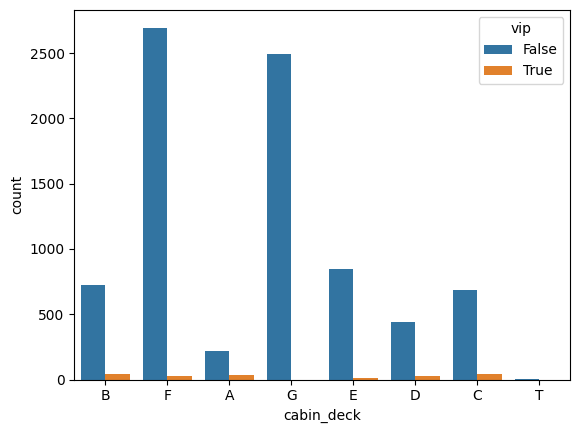

In [20]:
sns.countplot(X.cabin_deck, hue=X.vip)

<AxesSubplot:xlabel='cabin_deck', ylabel='cabin_num'>

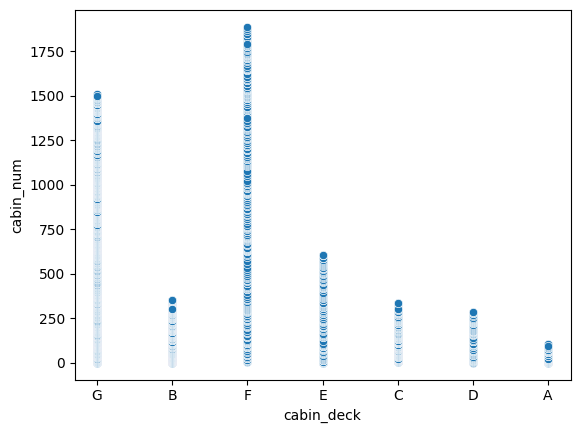

In [21]:
# plot the spread of cryo_sleep values throughout the cabin

X_cryo = X[X.cryo_sleep == 1]

sns.scatterplot(x='cabin_deck', y='cabin_num', data=X_cryo)

<AxesSubplot:xlabel='cabin_deck', ylabel='cabin_num'>

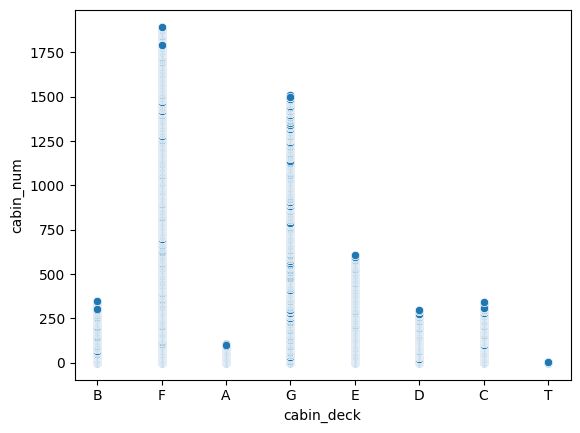

In [22]:
X_no_cryo = X[X.cryo_sleep == 0]

sns.scatterplot(x='cabin_deck', y='cabin_num', data=X_no_cryo)

<AxesSubplot:xlabel='cabin_side', ylabel='Count'>

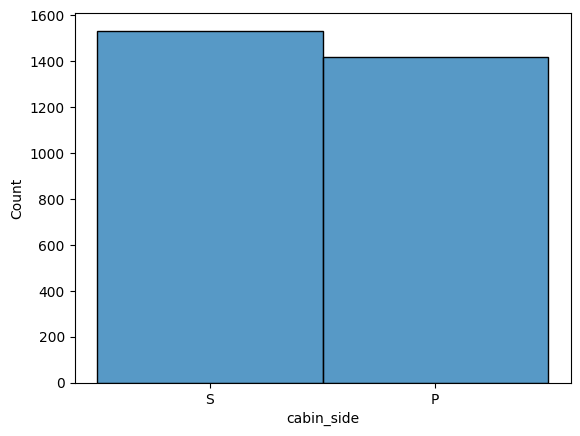

In [23]:
sns.histplot(x = X_cryo.cabin_side)

<AxesSubplot:xlabel='cabin_side', ylabel='Count'>

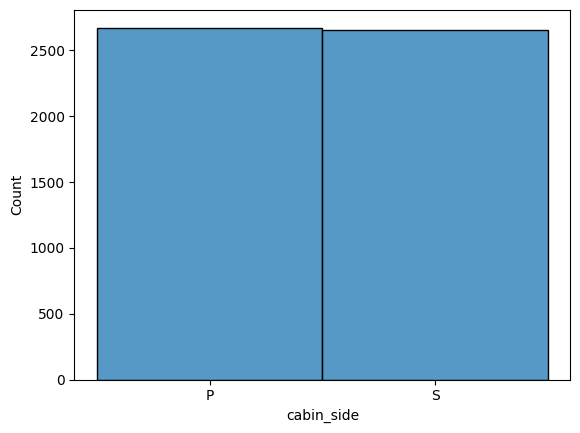

In [24]:
sns.histplot(x = X_no_cryo.cabin_side)

There doesn't seem to be a pattern between passengers being in cryo and their cabin. Maybe we can assume 0 spendings everywhere correlates with being in cryo?

In [25]:
# make a column for service total

def calculate_service_total(df):
    df['service_total'] = df.room_service + df.food_court + df.shopping_mall + df.spa + df.vr_deck
    return df

X = calculate_service_total(X)

In [26]:
# plot non cryo passengers that spent nothing on services

X_no_cryo = X[X.cryo_sleep == 0]
X_no_cryo[X_no_cryo.service_total == 0].count()

home_planet      446
cryo_sleep       459
destination      449
age              452
vip              445
room_service     459
food_court       459
shopping_mall    459
spa              459
vr_deck          459
cabin_deck       459
cabin_num        459
cabin_side       459
service_total    459
dtype: int64

In [27]:
X_no_cryo.service_total.isna().sum()

528

<AxesSubplot:xlabel='Transported', ylabel='count'>

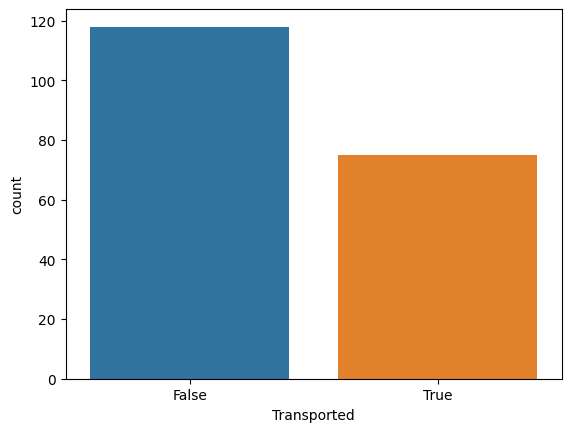

In [28]:
# spread of people who got transported based on service total

X_vis = pd.concat([X, y], axis=1)
sns.countplot(x='Transported', data=X_vis[X_vis.vip == 1])

In [29]:
# how many rows of X have missing values for vip and service total

X[X.vip.isna() & X.service_total.isna()].count()

home_planet      15
cryo_sleep       13
destination      15
age              15
vip               0
room_service     11
food_court       11
shopping_mall    11
spa              13
vr_deck          14
cabin_deck       15
cabin_num        15
cabin_side       15
service_total     0
dtype: int64

I don't trust this 100%, there seem to be too many NAs in service total - probably struggling to calculate when there are NAs in the service cols. I'll try to impute the NAs in the service cols with 0s and see if that helps.

In [30]:
X.shape

(8494, 14)

In [31]:
# drop the rows that have NAs for vip and every service column

X.dropna(subset=['vip', 'room_service', 'food_court', 'shopping_mall', 'spa', 'vr_deck'], how = 'all', inplace=True)

In [32]:
X.shape

(8494, 14)

In [33]:
X_test = test_data.drop(['PassengerId', 'Name'], axis=1)

snake_case_columns(X_test)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0
4273,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0
4274,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0
4275,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0


In [34]:
X_test.dropna(subset=['vip', 'room_service', 'food_court', 'shopping_mall', 'spa', 'vr_deck'], how='all', inplace=True)
X_test.shape

(4277, 11)

In [35]:
# imputer for the service columns

service_imputer = SimpleImputer(strategy='constant', fill_value=0)

# define service cols

service_cols = ['room_service', 'food_court', 'shopping_mall', 'spa', 'vr_deck']

# apply imputer to service columns

X[service_cols] = service_imputer.fit_transform(X[service_cols])

In [36]:
X = calculate_service_total(X)

In [37]:
X.isna().sum()

home_planet      195
cryo_sleep       210
destination      178
age              175
vip              197
room_service       0
food_court         0
shopping_mall      0
spa                0
vr_deck            0
cabin_deck         0
cabin_num          0
cabin_side         0
service_total      0
dtype: int64

In [38]:
# calculate the average service total for VIP passengers

vip_service_avg = X[X.vip == 1].service_total.mean()
vip_service_avg

4345.4715025906735

In [39]:
non_vip_service_avg = X[X.vip == 0].service_total.mean()
non_vip_service_avg

1369.5824284304047

In [40]:
# impute the service total for VIP passengers

X.loc[(X.vip == 1) & (X.service_total is None), 'service_total'] = vip_service_avg

# impute the service total for non-VIP passengers

X.loc[(X.vip == 0) & (X.service_total is None), 'service_total'] = non_vip_service_avg

In [41]:
X.isna().sum()

home_planet      195
cryo_sleep       210
destination      178
age              175
vip              197
room_service       0
food_court         0
shopping_mall      0
spa                0
vr_deck            0
cabin_deck         0
cabin_num          0
cabin_side         0
service_total      0
dtype: int64

In [42]:
X.vip.value_counts()

False    8104
True      193
Name: vip, dtype: int64

In [43]:
X.vip = X.vip.astype(bool)

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8494 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   home_planet    8299 non-null   object 
 1   cryo_sleep     8284 non-null   object 
 2   destination    8316 non-null   object 
 3   age            8319 non-null   float64
 4   vip            8494 non-null   bool   
 5   room_service   8494 non-null   float64
 6   food_court     8494 non-null   float64
 7   shopping_mall  8494 non-null   float64
 8   spa            8494 non-null   float64
 9   vr_deck        8494 non-null   float64
 10  cabin_deck     8494 non-null   object 
 11  cabin_num      8494 non-null   int64  
 12  cabin_side     8494 non-null   object 
 13  service_total  8494 non-null   float64
dtypes: bool(1), float64(7), int64(1), object(5)
memory usage: 937.3+ KB


In [45]:
vip_imputer = KNNImputer(n_neighbors=10)


In [46]:
X.isna().sum()

home_planet      195
cryo_sleep       210
destination      178
age              175
vip                0
room_service       0
food_court         0
shopping_mall      0
spa                0
vr_deck            0
cabin_deck         0
cabin_num          0
cabin_side         0
service_total      0
dtype: int64

In [47]:
X['vip'] = vip_imputer.fit_transform(X[['vip']])

In [48]:
X.vip.value_counts()

0.0    8104
1.0     390
Name: vip, dtype: int64

In [49]:
X.isna().sum()

home_planet      195
cryo_sleep       210
destination      178
age              175
vip                0
room_service       0
food_court         0
shopping_mall      0
spa                0
vr_deck            0
cabin_deck         0
cabin_num          0
cabin_side         0
service_total      0
dtype: int64

In [50]:
X.groupby('vip').count()

,home_planet,cryo_sleep,destination,age,room_service,food_court,shopping_mall,spa,vr_deck,cabin_deck,cabin_num,cabin_side,service_total
vip,,,,,,,,,,,,,
0.0,7917,7904,7932,7935,8104,8104,8104,8104,8104,8104,8104,8104,8104
1.0,382,380,384,384,390,390,390,390,390,390,390,390,390


In [51]:
X.isna().sum()

home_planet      195
cryo_sleep       210
destination      178
age              175
vip                0
room_service       0
food_court         0
shopping_mall      0
spa                0
vr_deck            0
cabin_deck         0
cabin_num          0
cabin_side         0
service_total      0
dtype: int64

In [52]:
age_imputer = SimpleImputer(strategy='median')

X['age'] = age_imputer.fit_transform(X[['age']])

In [53]:
X.isna().sum()

home_planet      195
cryo_sleep       210
destination      178
age                0
vip                0
room_service       0
food_court         0
shopping_mall      0
spa                0
vr_deck            0
cabin_deck         0
cabin_num          0
cabin_side         0
service_total      0
dtype: int64

<AxesSubplot:xlabel='cryo_sleep', ylabel='count'>

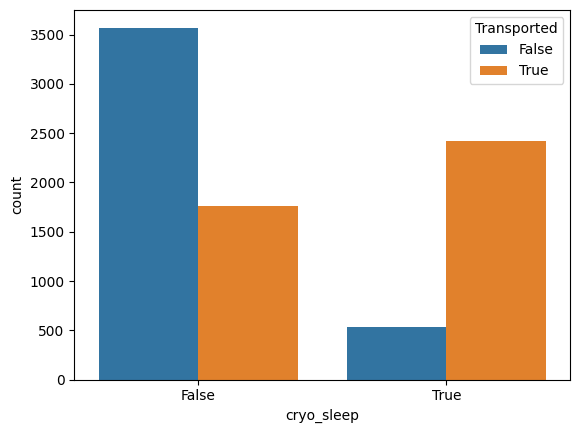

In [54]:
sns.countplot(x='cryo_sleep', hue='Transported', data=X_vis)

Very sus

In [55]:
X.cryo_sleep = X.cryo_sleep.astype(bool)

In [56]:
if X.cryo_sleep is None and X.service_total > 0:
    cryo_sleep = 1

In [57]:
X.isna().sum()

home_planet      195
cryo_sleep         0
destination      178
age                0
vip                0
room_service       0
food_court         0
shopping_mall      0
spa                0
vr_deck            0
cabin_deck         0
cabin_num          0
cabin_side         0
service_total      0
dtype: int64

In [58]:
X.drop(columns=['home_planet', 'destination'], inplace=True)

# Model - SVM

In [59]:
y.shape

(8494,)

In [60]:
scaler = StandardScaler()
X[['age', 'cabin_num']] = scaler.fit_transform(X[['age', 'cabin_num']])

X = pd.get_dummies(X, columns=['cabin_deck', 'cabin_side'])

model = SVC()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy_score(y_val, y_pred)


0.8057680988816951

# Make a Pipeline for the model

In [74]:
X = train_data.drop(['Transported'], axis=1)


preproc = make_column_transformer(
    (FunctionTransformer(drop_pointless_columns()), ['PassengerId', 'Name']),
    (FunctionTransformer(calculate_service_total()), ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']),
    (FunctionTransformer(engineer_cabin_cols()), ['Cabin']),
    (StandardScaler(), ['Age', 'cabin_num']),
    (OneHotEncoder(), ['cabin_deck', 'cabin_side']),
    (SimpleImputer(strategy='constant', fill_value=0), ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']),
    (KNNImputer(n_neighbors=10), ['VIP']),
    (SimpleImputer(strategy='median'), ['Age']),
    (SimpleImputer(strategy='constant', fill_value=1), ['CryoSleep']),
    remainder='drop'
)

model = SVC()

pipeline = make_pipeline(preproc, model)

pipeline.fit(X, y)

pipeline.transform(X_test)

TypeError: drop_pointless_columns() missing 1 required positional argument: 'X'